### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**


** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [ ]:
import pandas as pd

In [ ]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv("/content/dataset.csv", delimiter=";")
df

,Comment
0,adaptasi drakor kenapa jadi macem adaptasi fil...
1,dulu waktu gw ada drama pentas buat ujian seko...
2,itu kalo anda mau belajar lah lulus aja kagak ...
3,betul bang abizhar sebenarnya msh bisa dibimbi...
4,karena rame gua penasaran liat interview abidz...
...,...
745,ga masalah kalo visual mah kan remake indo ini...
746,yang salah attitude abidzarnya sih dia bilang ...
747,yang kasihan bukan dia atau para fans tapi tim...
748,lagian zaman masih gatau target pasar netizen ...


** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

In [ ]:
import pandas as pd
import re
import html
import string

# Download NLTK for getting the stopwords
import nltk
nltk.download('stopwords')

# Use NLTK Corpus for stopwords dictionary
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


** **
Source of Abbrevation CSV. https://github.com/khumam/Singkatan

In [ ]:
# Download Abbreviation CSV
!wget -O abbreviation.csv \
https://raw.githubusercontent.com/khumam/Singkatan/master/src/Singkatan/Dictionary/singkatan.csv


--2025-12-16 08:25:51--  https://raw.githubusercontent.com/khumam/Singkatan/master/src/Singkatan/Dictionary/singkatan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17601 (17K) [text/plain]
Saving to: ‘abbreviation.csv’

abbreviation.csv    100%[===================>]  17.19K  --.-KB/s    in 0.001s  

2025-12-16 08:25:51 (14.3 MB/s) - ‘abbreviation.csv’ saved [17601/17601]



In [ ]:
# Import singkatan.csv for normalize abbreviation and set name colums
abbreviation = pd.read_csv("/content/abbreviation.csv", delimiter=";", names=["abbreviation", "meaning"])
abbreviation.head()

,abbreviation,meaning
0,aamiin,amin
1,adek,adik
2,adlh,adalah
3,aer,air
4,aiskrim,es krim


In [ ]:
# Set into type dictionary for abbreviation corpus
abbr_dict = dict(
    zip(abbreviation["abbreviation"], abbreviation["meaning"])
)
abbr_dict

{'aamiin': 'amin ',
 'adek': 'adik ',
 'adlh': 'adalah ',
 'aer': 'air ',
 'aiskrim': 'es krim ',
 'aj': 'saja ',
 'aja': 'saja ',
 'ajah': 'saja ',
 'ajalah': 'saja ',
 'aje': 'saja ',
 'ajh': 'saja',
 'ajj': 'saja',
 'aku': 'saya',
 'ak': 'saya ',
 'akoh': 'saya',
 'akutu': 'saya',
 'aq': 'saya',
 'alesan': 'alasan ',
 'ama': 'sama ',
 'amaca': 'ah masa',
 'amuh': 'kamu',
 'ancur': 'hancur ',
 'ane': 'saya ',
 'anget': 'hangat ',
 'anjeng': 'anjing ',
 'ank': 'anak ',
 'apah': 'apa ',
 'aph': 'apa',
 'apo': 'apa ',
 'apose': 'apa',
 'apz': 'apa',
 'artine': 'artinya ',
 'asek': 'asik ',
 'ati2': 'hati-hati ',
 'atit': 'sakit ',
 'atu': 'satu ',
 'atw': 'atau ',
 'ayang': 'sayang ',
 'ayuk': 'ayo ',
 'babang': 'abang',
 'bae': 'baik ',
 'bais': 'habis',
 'bakalan': 'akan ',
 'bales': 'balas ',
 'bandingin': 'bandingkan ',
 'banget': 'sekali ',
 'bangett': 'sangat ',
 'banyakin': 'perbanyak ',
 'barengan': 'bersamaan ',
 'baryaw': 'sabar ya',
 'baso': 'bakso ',
 'bay': 'selamat tinggal

In [ ]:
from nltk.corpus import stopwords

# Indonesian stopwords
sw_indo = set(stopwords.words("indonesian"))

# custom stopwords (lowercase!)
custom_stopwords = [
    "yang", "saja", "nya", "begitu", "memang", "bilang", "sama", "film", "sih", "karena", "si", "drama", "tidak",
    "kali", "ya", "salah", "bikin", "pas", "mah", "orang", "gimana", "aslinya", "tuh", "filmnya", "nonton",
    "pakai", "liat", "baca", "tuh", "bang", "main", "kaya", "korea", "netizen", "jujur", "indo", "biar",
    "cocok", "kek", "suka", "anak", "minimal", "asli", "kdrama", "belajar", "sekolah", "apapun", "kpop",
    "langsung", "loh", "namanya", "ceritanya", "jam", "kena", "beda", "ikuti", "intinya", "nih", "deh", "apa",
    "kasih", "tidak", "dn", "warkop", "mending", "in"
]

# update stopwords
sw_indo.update(custom_stopwords)

In [ ]:
# Declare function for handle abbreviation problem
def preprocess_abbreviation(text, dict=abbr_dict):
    # Set lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)

    # List of tokens from a sentence
    words_list = text.split()

    # Checking for abbreviation validation
    expanded = [dict.get(w, w) for w in words_list]

    # Remove strip in token
    cleaned = [w.strip() for w in expanded]

    # Remove stopwords
    filtered = [w.strip() for w in cleaned if w not in sw_indo]

    # Concat token to sentence again
    text = " ".join(filtered)

    # normalisasi whitespace again
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df["text_processed"] = df["Comment"].apply(preprocess_abbreviation)

** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

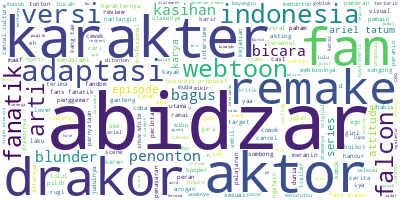

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(df['text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=5, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

In [ ]:
!pip install gensim -qq

In [ ]:
import gensim
from gensim.utils import simple_preprocess

# Tokenizing the text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

In [ ]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"abidzar" + 0.010*"fans" + 0.009*"karakter" + 0.008*"adaptasi" + '
  '0.007*"falcon" + 0.007*"drakor" + 0.006*"fanatik" + 0.005*"penggemar" + '
  '0.005*"public" + 0.005*"remake"'),
 (1,
  '0.012*"drakor" + 0.012*"remake" + 0.011*"abidzar" + 0.007*"bicara" + '
  '0.007*"artis" + 0.006*"karakter" + 0.005*"aktor" + 0.005*"series" + '
  '0.004*"culture" + 0.004*"cerita"'),
 (2,
  '0.043*"abidzar" + 0.012*"adaptasi" + 0.011*"webtoon" + 0.010*"karakter" + '
  '0.008*"drakor" + 0.008*"aktor" + 0.007*"indonesia" + 0.006*"utama" + '
  '0.005*"tae" + 0.005*"versi"'),
 (3,
  '0.020*"abidzar" + 0.015*"episode" + 0.012*"ariel" + 0.010*"karakter" + '
  '0.010*"tatum" + 0.009*"versi" + 0.008*"tidak" + 0.006*"target" + '
  '0.006*"bicara" + 0.005*"falcon"'),
 (4,
  '0.021*"fans" + 0.009*"fanatik" + 0.009*"drakor" + 0.008*"white" + '
  '0.008*"snow" + 0.008*"abidzar" + 0.006*"indonesia" + 0.006*"versi" + '
  '0.006*"aktor" + 0.006*"karakter"'),
 (5,
  '0.014*"attitude" + 0.012*"aktor" + 